# Discovering Reddit Sentiment Stock Trends

Methods used includes Logistic Regression, Naive Bayes Gaussian, Naive Bayes Categorical, and Neural Networks


# Import Tools


In [76]:
# Import libraries
import pandas as pd
import numpy as np

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# EDA
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter

# Module with the deprecation in python version 3.7 and above
# However, works fine for me in python version 3.9.1
# Commented it out just to be safe
#%pip install wordcloud
#from wordcloud import WordCloud, STOPWORDS

# Cleaning up the text
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Splitting for test and train sets
from sklearn.model_selection import train_test_split

# Neural Network
from keras.utils import np_utils

print("Completed importing tools")


Completed importing tools


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\trane\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\trane\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Reddit Dataset


In [77]:
# Import reddit dataset
og_reddit = pd.read_csv('reddit_wsb.csv')
og_reddit.head()


,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


# Preprocess Reddit Dataset


In [78]:
# Removed columns that I felt unnecessary
bad_reddit = ['score', 'id', 'url',
              'comms_num', 'created', 'body', 'timestamp']
clean_reddit = og_reddit.drop(bad_reddit, axis=1)
clean_reddit.head()


,title
0,"It's not about the money, it's about sending a..."
1,Math Professor Scott Steiner says the numbers ...
2,Exit the system
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...
4,"Not to distract from GME, just thought our AMC..."


In [79]:
# Number of cases
print('Number of Reddit Titles:', len(clean_reddit['title']))

Number of Reddit Titles: 53187


In [80]:
# Referenced: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python

# Functions to cleanup the text
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', str(text))
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", re.UNICODE)
    text = re.sub(emoji_pattern, '', text)  # no emoji
    return text


# Function that applies cleaning to df
def clean_text_up(df):
    for i in range(df.shape[0]):
        df.iat[i, 0] = clean_text(df.iat[i, 0])


In [81]:
# Clean the text
clean_text_up(clean_reddit)
clean_reddit.head()


,title
0,its not about the money its about sending a me...
1,math professor scott steiner says the numbers ...
2,exit the system
3,new sec filing for gme can someone less retard...
4,not to distract from gme just thought our amc ...


# Preprocess NYSE Dataset


In [82]:
# Import NYSE dataset
og_NYSE = pd.read_csv('NYSE_20211119.csv')
og_NYSE


,Symbol,Date,Open,High,Low,Close,Volume
0,A,19-Nov-2021,163.01,165.0700,162.67,164.3000,1647600
1,AA,19-Nov-2021,47.31,48.0800,46.69,47.6000,5644100
2,AAC,19-Nov-2021,9.84,9.8400,9.79,9.8200,993400
3,AAC.U,19-Nov-2021,10.08,10.0800,10.03,10.0600,12300
4,AAC.W,19-Nov-2021,1.24,1.3000,1.24,1.2999,18300
...,...,...,...,...,...,...,...
3492,ZTS,19-Nov-2021,226.50,228.3300,224.20,226.4300,1734700
3493,ZUO,19-Nov-2021,22.52,22.7100,22.00,22.0900,596400
3494,ZVIA,19-Nov-2021,8.24,8.2835,7.72,7.9300,405500
3495,ZWS,19-Nov-2021,37.90,38.3150,37.69,37.9000,665300


In [83]:
# Removed columns that I felt unnecessary
bad_NYSE = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
clean_NYSE = og_NYSE.drop(bad_NYSE, axis=1)
clean_NYSE.head()


,Symbol
0,A
1,AA
2,AAC
3,AAC.U
4,AAC.W


In [84]:
# Clean the text
# Must apply since I did for reddit dataset
clean_text_up(clean_NYSE)
clean_NYSE.head()


,Symbol
0,a
1,aa
2,aac
3,aacu
4,aacw


# Find Sentiment Scores


In [85]:
# Find sentiment scores
analyser = SentimentIntensityAnalyzer()

scores = []
for item in clean_reddit['title']:
    score = analyser.polarity_scores(item)
    scores.append(score)

scores_df = pd.DataFrame(scores)
scores_df.head()


,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.272,0.728,0.000,-0.6249
2,0.000,1.000,0.000,0.0000
3,0.204,0.658,0.138,-0.2748
4,0.000,0.881,0.119,0.2235


In [86]:
# Combine clean_reddit and scores_df dataframes
combine_df = pd.concat([clean_reddit, scores_df], axis=1, join='inner')
combine_df.head()


,title,neg,neu,pos,compound
0,its not about the money its about sending a me...,0.000,1.000,0.000,0.0000
1,math professor scott steiner says the numbers ...,0.272,0.728,0.000,-0.6249
2,exit the system,0.000,1.000,0.000,0.0000
3,new sec filing for gme can someone less retard...,0.204,0.658,0.138,-0.2748
4,not to distract from gme just thought our amc ...,0.000,0.881,0.119,0.2235


# Preprocess new data


In [87]:
# Find the class of each title based off greatest value between neg, neu, pos columns
combine_df['class'] = combine_df[['neg', 'neu', 'pos']].idxmax(axis=1)
combine_df.head()


,title,neg,neu,pos,compound,class
0,its not about the money its about sending a me...,0.000,1.000,0.000,0.0000,neu
1,math professor scott steiner says the numbers ...,0.272,0.728,0.000,-0.6249,neu
2,exit the system,0.000,1.000,0.000,0.0000,neu
3,new sec filing for gme can someone less retard...,0.204,0.658,0.138,-0.2748,neu
4,not to distract from gme just thought our amc ...,0.000,0.881,0.119,0.2235,neu


In [88]:
# Remove all neutral classes
# Neutral classes will have insignificant value
combine_df = combine_df[combine_df['class'] != 'neu']
combine_df.reset_index(drop=True, inplace=True)
combine_df.head()


,title,neg,neu,pos,compound,class
0,i love you retards,0.000,0.417,0.583,0.6369,pos
1,,0.000,0.000,0.000,0.0000,neg
2,the wallstreetbets war museum,0.565,0.435,0.000,-0.5994,neg
3,most recent short interest,0.000,0.479,0.521,0.5046,pos
4,i love the movies part,0.000,0.488,0.512,0.6369,pos


In [89]:
# Remove all 0 compound
# Compound value of 0 will have insignificant value
combine_df = combine_df[combine_df['compound'] != 0]
combine_df.reset_index(drop=True, inplace=True)
combine_df.head()


,title,neg,neu,pos,compound,class
0,i love you retards,0.000,0.417,0.583,0.6369,pos
1,the wallstreetbets war museum,0.565,0.435,0.000,-0.5994,neg
2,most recent short interest,0.000,0.479,0.521,0.5046,pos
3,i love the movies part,0.000,0.488,0.512,0.6369,pos
4,i see dead hedge funds,0.518,0.482,0.000,-0.6486,neg


In [90]:
# Tokenize text
combine_df['title'] = combine_df['title'].apply(word_tokenize)
combine_df.head()


,title,neg,neu,pos,compound,class
0,"[i, love, you, retards]",0.000,0.417,0.583,0.6369,pos
1,"[the, wallstreetbets, war, museum]",0.565,0.435,0.000,-0.5994,neg
2,"[most, recent, short, interest]",0.000,0.479,0.521,0.5046,pos
3,"[i, love, the, movies, part]",0.000,0.488,0.512,0.6369,pos
4,"[i, see, dead, hedge, funds]",0.518,0.482,0.000,-0.6486,neg


In [91]:
# Remove stopwords
# Removing some stopwords will result in removing some stock tickers
# For ex. SEE, YOU, etc
def remove_stopwords(input):
    words = []
    for word in input:
        if word not in stopwords.words('english'):
            words.append(word)
    return words


combine_df['title'] = combine_df['title'].apply(remove_stopwords)
combine_df.head()


,title,neg,neu,pos,compound,class
0,"[love, retards]",0.000,0.417,0.583,0.6369,pos
1,"[wallstreetbets, war, museum]",0.565,0.435,0.000,-0.5994,neg
2,"[recent, short, interest]",0.000,0.479,0.521,0.5046,pos
3,"[love, movies, part]",0.000,0.488,0.512,0.6369,pos
4,"[see, dead, hedge, funds]",0.518,0.482,0.000,-0.6486,neg


In [92]:
# Perform lemma
lem = WordNetLemmatizer()


def lemma_wordnet(input):
    return [lem.lemmatize(w) for w in input]


combine_df['title'] = combine_df['title'].apply(lemma_wordnet)
combine_df.head()


,title,neg,neu,pos,compound,class
0,"[love, retard]",0.000,0.417,0.583,0.6369,pos
1,"[wallstreetbets, war, museum]",0.565,0.435,0.000,-0.5994,neg
2,"[recent, short, interest]",0.000,0.479,0.521,0.5046,pos
3,"[love, movie, part]",0.000,0.488,0.512,0.6369,pos
4,"[see, dead, hedge, fund]",0.518,0.482,0.000,-0.6486,neg


In [93]:
# Output 1 or 0 if stock ticker is found in title
searchfor = clean_NYSE['Symbol']
combine_df["TrueFalse"] = combine_df['title'].apply(
    lambda x: 1 if any(i in x for i in searchfor) else 0)
combine_df.head()


,title,neg,neu,pos,compound,class,TrueFalse
0,"[love, retard]",0.000,0.417,0.583,0.6369,pos,0
1,"[wallstreetbets, war, museum]",0.565,0.435,0.000,-0.5994,neg,0
2,"[recent, short, interest]",0.000,0.479,0.521,0.5046,pos,0
3,"[love, movie, part]",0.000,0.488,0.512,0.6369,pos,0
4,"[see, dead, hedge, fund]",0.518,0.482,0.000,-0.6486,neg,1


In [94]:
# Remove all rows with no stock tickers
# It will probably remove non-acronym stocks
combine_df = combine_df[combine_df.TrueFalse != 0]
combine_df.reset_index(drop=True, inplace=True)
combine_df.head()


,title,neg,neu,pos,compound,class,TrueFalse
0,"[see, dead, hedge, fund]",0.518,0.482,0.000,-0.6486,neg,1
1,"[thank, mod, team, glorious, retard]",0.000,0.427,0.573,0.7717,pos,1
2,"[thank, mod]",0.000,0.444,0.556,0.3612,pos,1
3,"[best, broker, europe]",0.000,0.417,0.583,0.6369,pos,1
4,[wow],0.000,0.000,1.000,0.5859,pos,1


In [95]:
# Remove TrueFalse column
combine_df = combine_df.drop('TrueFalse', 1)
combine_df.head()


,title,neg,neu,pos,compound,class
0,"[see, dead, hedge, fund]",0.518,0.482,0.000,-0.6486,neg
1,"[thank, mod, team, glorious, retard]",0.000,0.427,0.573,0.7717,pos
2,"[thank, mod]",0.000,0.444,0.556,0.3612,pos
3,"[best, broker, europe]",0.000,0.417,0.583,0.6369,pos
4,[wow],0.000,0.000,1.000,0.5859,pos


In [96]:
# Join the text
for i in range(combine_df.shape[0]):
    combine_df.iat[i, 0] = ' '.join(combine_df.iat[i, 0])
combine_df.head()


,title,neg,neu,pos,compound,class
0,see dead hedge fund,0.518,0.482,0.000,-0.6486,neg
1,thank mod team glorious retard,0.000,0.427,0.573,0.7717,pos
2,thank mod,0.000,0.444,0.556,0.3612,pos
3,best broker europe,0.000,0.417,0.583,0.6369,pos
4,wow,0.000,0.000,1.000,0.5859,pos


In [97]:
# Replace neg and pos to 0s and 1s
combine_df['class'][combine_df['class'] == 'neg'] = 0
combine_df['class'][combine_df['class'] == 'pos'] = 1
combine_df.head()


<ipython-input-97-0c9039f2b123>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-97-0c9039f2b123>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title,neg,neu,pos,compound,class
0,see dead hedge fund,0.518,0.482,0.000,-0.6486,0
1,thank mod team glorious retard,0.000,0.427,0.573,0.7717,1
2,thank mod,0.000,0.444,0.556,0.3612,1
3,best broker europe,0.000,0.417,0.583,0.6369,1
4,wow,0.000,0.000,1.000,0.5859,1


In [98]:
# Create a copy
final_df = combine_df[['title', 'class']].copy()
final_df.head()


,title,class
0,see dead hedge fund,0
1,thank mod team glorious retard,1
2,thank mod,1
3,best broker europe,1
4,wow,1


# Basic EDA


In [99]:
# Print the total cases
print('Positive Sentiment:', len(final_df[final_df['class'] == 1]))
print('Negative Sentiment:', len(final_df[final_df['class'] == 0]))
print('Total Cases:', len(final_df))


Positive Sentiment: 806
Negative Sentiment: 305
Total Cases: 1111


<AxesSubplot:>

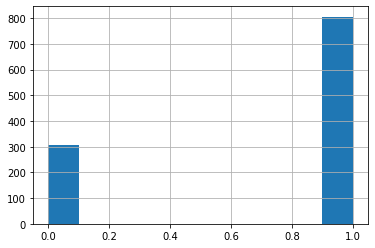

In [100]:
# Print the final results
final_df["class"].hist()


Text(0, 0.5, 'Negative')

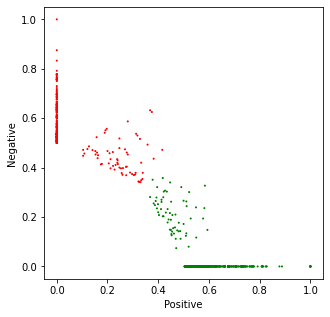

In [101]:
# Plotting Positive and Negative Sentiments
# Output will show that good seperation
# Accuracy should be fairly high
X_axis = combine_df[['pos', 'neg']].values
Y_axis = combine_df['class'].values
fig, ax = plt.subplots(figsize=(5, 5))
colors = ['red', 'green']
ax.scatter(X_axis[:, 0], X_axis[:, 1], c=[colors[int(k)]
                                          for k in Y_axis], s=1)
plt.xlabel("Positive")
plt.ylabel("Negative")


In [102]:
'''
# Find common words
# wordcloud is deprecated in python version 3.7 and above
# for some reason, it works fine for me on version 3.9.1
# Commented out just to be safe
body_list = final_df.title.tolist()
fig_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='lightgrey',
                          colormap='viridis', width=800, height=600
                          ).generate(' '.join(body_list))

plt.figure(figsize=(10, 7), frameon=True)
plt.imshow(fig_wordcloud)
plt.axis('off')
plt.show()
'''

"\n# Find common words\n# wordcloud is deprecated in python version 3.7 and above\n# for some reason, it works fine for me on version 3.9.1\n# Commented out just to be safe\nbody_list = final_df.title.tolist()\nfig_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='lightgrey',\n                          colormap='viridis', width=800, height=600\n                          ).generate(' '.join(body_list))\n\nplt.figure(figsize=(10, 7), frameon=True)\nplt.imshow(fig_wordcloud)\nplt.axis('off')\nplt.show()\n"

In [103]:
# Find common words
common = pd.DataFrame()
common['words'] = final_df['title'].apply(word_tokenize)
top = Counter([item for sublist in common['words'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp = temp.iloc[1:, :]
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Purples')


,Common_words,count
1,gme,238
2,amc,111
3,gain,78
4,pltr,74
5,share,66
6,update,57
7,best,53
8,well,53
9,rkt,49


In [104]:
# common words
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h',
             width=700, height=700, color='Common_words')
fig.show()


# Apply Logistics Regression


In [105]:
# X: read only "title", text
# Y: read only "class", 0s and 1s
X = final_df['title'].values
y = final_df['class'].values


In [106]:
# Create training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0)


In [107]:
# Change datatype and reshape
y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


In [108]:
# Removing stopwords and stemming for better accuracy
def clean_stopword_lemma(title):
    lem = WordNetLemmatizer()
    title = title.lower()
    sw_nltk = set(stopwords.words('english'))
    word_tokens = word_tokenize(title)

    cleaned = [w for w in word_tokens if not w.lower() in sw_nltk]

    cleaned = []

    for w in word_tokens:
        if w not in sw_nltk and w not in string.punctuation:
            lemma = lem.lemmatize(w)
            cleaned.append(lemma)
    return cleaned


# Test
text = "AMC GME PLTR Natural language processing (NLP) is a field "
clean_stopword_lemma(text)


['amc', 'gme', 'pltr', 'natural', 'language', 'processing', 'nlp', 'field']

In [109]:
# Get frequency dictionary
# reddit: a list of reddit titles
# ys: an m x 1 array with the sentiment label of each title (either 0 or 1)
# squeeze(): Remove single-dimensional entries from the shape of an array.
#  zip(): function accepts iterable items and merges them into a single tuple.
def reddit_freqs(reddit, ys):
    # Convert np array to list since zip needs an iterable.
    yslist = np.squeeze(ys).tolist()
    # Count freqs and generate dictionary
    freqs = {}
    for yt, title in zip(yslist, reddit):
        for word in clean_stopword_lemma(title):
            # define the key, which is the word and label tuple
            pair = (word, yt)
            # if the key exists in the dictionary, increment the count
            if pair in freqs:
                freqs[pair] += 1
            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                freqs[pair] = 1
    return freqs


freqs = reddit_freqs(X_train, y_train)
# Test
# print(freqs)


In [110]:
# Get sigmoid
def sigmoid(z):
    return (1 / (1 + np.exp(-z)))


In [111]:
# Apply gradient descent
def gradientDescent(x, y, theta, alpha, iter):
    # get 'm', the number of rows in matrix x
    m = x.shape[0]

    for i in range(0, iter):

        # get z, the dot product of x and theta
        z = np.dot(x, theta)

        # get the sigmoid of h
        h = sigmoid(z)

        # calculate the cost function
        J = (-1/m) * (np.dot((y.transpose()), np.log(h)) +
                      np.dot((1 - y).transpose(), np.log(1 - h)))

        # update the weights theta
        theta = theta - (alpha/m) * np.dot(x.T, (h - y))

    J = float(J)

    return J, theta


In [112]:
# Get the features
def extract_features(title, freqs):
    # clean the titles
    word_list = clean_stopword_lemma(title)
    # x is a 1 x 3 matrix
    x = np.zeros((1, 3))
    # bias is set to 1
    x[0, 0] = 1
    # loop through each word in the list of words
    for word in word_list:
        # increment the word count for the positive label 1
        x[0, 1] += freqs.get((word, 1.0), 0)
        # increment the word count for the negative label 0
        x[0, 2] += freqs.get((word, 0.0), 0)
    return x


In [113]:
# Train the model
# Stack the features for all training examples into a matrix X.
# Call gradientDescent
# squeeze: Remove single-dimensional entries from the shape of an array.
def train_logistic_regression(freqs, X_train, y_train):
    # collect the features x and stack them into a matrix X
    X = np.zeros((len(X_train), 3))
    for i in range(len(X_train)):
        X[i, :] = extract_features(X_train[i], freqs)

    # training labels corresponding to X
    Y = y_train

    # Apply gradient descent
    J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-5, 15000)

    return J, theta


J, theta = train_logistic_regression(freqs, X_train, y_train)

print(f"The cost after training is {J:.8f}.")

print(
    f"The resulting weight vector is {[round(t, 8) for t in np.squeeze(theta)]}")


The cost after training is 0.40540780.
The resulting weight vector is [0.00437096, 0.03177147, -0.05450412]


In [114]:
# Predict whether a title is positive or negative.
def predict_logistic_regression(title, freqs, theta):
    # extract the features of the title and store it into x
    x = extract_features(title, freqs)
    # make the prediction using the features and theta
    y_pred = sigmoid(np.dot(x, theta))

    return y_pred


# Logistics Regression Results


In [115]:
# Given the test data and the weights of the trained model,
# Use predict() function to make predictions on each title in the test set.
# Get accuracy
def logisticRegression(X_test, y_test, freqs, theta):
    # the list for storing predictions
    y_hat = []

    for title in X_test:
        # get the label prediction for the title
        y_pred = predict_logistic_regression(title, freqs, theta)

        if y_pred > 0.5:
            # pred > 0.5 then append 1.0 to the list
            y_hat.append(1.0)
        else:
            # pred < 0.5 then append 0 to the list
            y_hat.append(0.0)

    # y_hat is a list, but y_test is (m,1) array
    # convert both to one-dimensional arrays in order to compare them
    # squeeze: Remove single-dimensional entries from the shape of an array.
    accuracy = (np.array((y_hat)) == np.squeeze(y_test)).mean()

    return accuracy


# Apply logistic Regression and print model accuracy
accuracy = logisticRegression(X_test, y_test, freqs, theta)
print(f"Logistic regression model's accuracy = {accuracy:.4f}")


Logistic regression model's accuracy = 0.9193


In [116]:
# Gather Results
results = pd.DataFrame([['Logistics Regression', accuracy]],
               columns = ['Model', 'Accuracy'])

results

,Model,Accuracy
0,Logistics Regression,0.919283


In [117]:
# Apply prediction to all titles
y_hat = []
for text in final_df['title']:
    print(clean_stopword_lemma(text))
    y_pred = predict_logistic_regression(text, freqs, theta)
    print(y_pred)
    if y_pred > 0.5:
        y_hat.append(1)
        print('Positive sentiment\n')
    else:
        y_hat.append(0)
        print('Negative sentiment\n')    


['see', 'dead', 'hedge', 'fund']
[[0.35960092]]
Negative sentiment

['thank', 'mod', 'team', 'glorious', 'retard']
[[0.50438049]]
Positive sentiment

['thank', 'mod']
[[0.52373973]]
Positive sentiment

['best', 'broker', 'europe']
[[0.8278138]]
Positive sentiment

['wow']
[[0.58203296]]
Positive sentiment

['gme', 'trust']
[[0.42377685]]
Negative sentiment

['free', 'gme']
[[0.47086824]]
Negative sentiment

['robinhood', 'gme', 'wtf']
[[0.28024236]]
Negative sentiment

['gme', 'longer', 'supported', 'robinhood']
[[0.27387881]]
Negative sentiment

['gme', 'great', 'work', 'bois']
[[0.55233124]]
Positive sentiment

['wow', 'robinhood']
[[0.50780343]]
Positive sentiment

['gme']
[[0.40068725]]
Negative sentiment

['wtf', 'rh']
[[0.24142725]]
Negative sentiment

['best', 'trading', 'app']
[[0.83913855]]
Positive sentiment

['cancel', 'robinhood', 'rh', 'screenshot', 'ban']
[[0.20301726]]
Negative sentiment

['gme', 'longer', 'supported', 'robinhood']
[[0.27387881]]
Negative sentiment

['sn

# Apply Naive Bayes Gaussian Method


In [118]:
# Using prof's naive bayes gaussian as reference
# Create a df for naive bayes
# I used neg, neu, and pos to determine whether its sentiment value
# In combine_df, I had already removed neutral classes
naive_df = combine_df[['neg', 'neu', 'pos', 'class']].copy()
naive_df.head()


,neg,neu,pos,class
0,0.518,0.482,0.000,0
1,0.000,0.427,0.573,1
2,0.000,0.444,0.556,1
3,0.000,0.417,0.583,1
4,0.000,0.000,1.000,1


In [119]:
# Calculate the prior belief
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y] == i])/len(df))
    return prior


# Test
calculate_prior(naive_df, Y="class")


[0.2745274527452745, 0.7254725472547254]

In [120]:
# Calculate the likelihood
# Calculate P(X=x|Y=y) using Gaussian dist.
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y] == label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) * \
        np.exp(-((feat_val-mean)**2 / (2 * std**2)))
    return p_x_given_y


In [121]:
# Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(
                    df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)


# Naive Bayes Gaussian Results


In [122]:
# Apply to naive bayes gaussian
train, test = train_test_split(naive_df, test_size=.2, random_state=41)

X_test = test.iloc[:, :-1].values
Y_test = test.iloc[:, -1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="class")

print(Y_test)
print(Y_pred)

# Gets an error saying that we have a regression problem
# Not a classification problem
# So we cannot use confusion matrix, or f1_score
'''
from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))
'''

# Decided to generate the confusion matrix by hand
# I found TP, TN, FP, FN by hand so some errors my occur
# Reference: https://towardsdatascience.com/taking-the-confusion-out-of-confusion-matrices-c1ce054b3d3e
TP = 166
FP = 0
TN = 56
FN = 1

# Confusion matrix by hand
cm = [[TP, FP],[FN, TN]]
print(cm)

# accuracy is too high to be called "good"
# I suspect that there is overfitting
accuracy = (TP+TN)/(TP+FP+TN+FN)
print(f"Naive Bayes Gaussian model's accuracy = {accuracy:.4f}")

[1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0
 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0
 1]
[1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0
 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0
 1]
[[166, 0], [1, 56]]
Naive Bayes Gaussian model's accuracy = 0.9955


In [123]:
# Gather results
model_results = pd.DataFrame([['Naive Bayes Gaussian', accuracy]],
               columns = ['Model', 'Accuracy'])
results = results.append(model_results, ignore_index = True)

results

,Model,Accuracy
0,Logistics Regression,0.919283
1,Naive Bayes Gaussian,0.995516


# Apply Naive Bayes Catergorical Method


In [124]:
# Convert continuous features to Categorical features
naive_df["cat_neg"] = pd.cut(
    naive_df["neg"].values, bins=3, labels=[0, 1, 2])
naive_df["cat_neu"] = pd.cut(
    naive_df["neu"].values, bins=3, labels=[0, 1, 2])
naive_df["cat_pos"] = pd.cut(
    naive_df["pos"].values, bins=3, labels=[0, 1, 2])

naive_df = naive_df.drop(columns=["neg", "neu", "pos"])
naive_df = naive_df[["cat_neg",	"cat_neu",	"cat_pos", "class"]]
naive_df.head(10)


,cat_neg,cat_neu,cat_pos,class
0,1,2,0,0
1,0,2,1,1
2,0,2,1,1
3,0,2,1,1
4,0,0,2,1
5,0,2,1,1
6,0,1,2,1
7,0,1,1,1
8,1,2,0,0
9,0,2,1,1


In [125]:
# Calculate P(X=x|Y=y) categorically
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y] == label]
    p_x_given_y = len(df[df[feat_name] == feat_val]) / len(df)
    return p_x_given_y


In [126]:
# Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(
                    df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)


# Naive Bayes Categorical Results


In [127]:
# Apply naive bayes categorical method
train, test = train_test_split(naive_df, test_size=.2, random_state=41)

X_test = test.iloc[:, :-1].values
Y_test = test.iloc[:, -1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="class")

print(Y_test)
print(Y_pred)

# Similar problem like in gaussian method
# Gets an error saying that we have a regression problem
# Not a classification problem
# So we cannot use confusion matrix, or f1_score
'''
from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))
'''

# Decided to generate the confusion matrix by hand
# I found TP, TN, FP, FN by hand so some errors my occur
# Reference: https://towardsdatascience.com/taking-the-confusion-out-of-confusion-matrices-c1ce054b3d3e
TP = 167
FP = 0
TN = 56
FN = 0

# Confusion matrix by hand
cm = [[TP, FP],[FN, TN]]
print(cm)

# accuracy is too high to be called "good"
# I suspect that there is overfitting
accuracy = (TP+TN)/(TP+FP+TN+FN)
print(f"Naive Bayes Categorical model's accuracy = {accuracy:.4f}")

[1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0
 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0
 1]
[1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0
 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0
 1]
[[167, 0], [0, 56]]
Naive Bayes Categorical model's accuracy = 1.0000


In [128]:
# Gather results
model_results = pd.DataFrame([['Naive Bayes Categorical', accuracy]],
               columns = ['Model', 'Accuracy'])
results = results.append(model_results, ignore_index = True)

results

,Model,Accuracy
0,Logistics Regression,0.919283
1,Naive Bayes Gaussian,0.995516
2,Naive Bayes Categorical,1.000000


# Apply Neural Network


In [129]:
class FCLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(
            input_size, output_size) / np.sqrt(input_size + output_size)
        self.bias = np.random.randn(
            1, output_size) / np.sqrt(input_size + output_size)

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # bias_error = output_error

        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error


In [130]:
class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward(self, input):
        self.input = input
        return self.activation(input)

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)


In [131]:
class FlattenLayer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward(self, input):
        return np.reshape(input, (1, -1))

    def backward(self, output_error, learning_rate):
        return np.reshape(output_error, self.input_shape)


In [132]:
class SoftmaxLayer:
    def __init__(self, input_size):
        self.input_size = input_size

    def forward(self, input):
        self.input = input
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output

    def backward(self, output_error, learning_rate):
        input_error = np.zeros(output_error.shape)
        out = np.tile(self.output.T, self.input_size)
        return self.output * np.dot(output_error, np.identity(self.input_size) - out)


In [133]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2


def tanh(x):
    return np.tanh(x)


def tanh_prime(x):
    return 1 - np.tanh(x)**2


def relu(x):
    return np.maximum(x, 0)


def relu_prime(x):
    return np.array(x >= 0).astype('int')


In [134]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))


def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size


def sse(y_true, y_pred):
    return 0.5 * np.sum(np.power(y_true - y_pred, 2))


def sse_prime(y_true, y_pred):
    return y_pred - y_true


In [135]:
nn_df = combine_df[['neg', 'neu', 'pos', 'class']].copy()
nn_df.head()

,neg,neu,pos,class
0,0.518,0.482,0.000,0
1,0.000,0.427,0.573,1
2,0.000,0.444,0.556,1
3,0.000,0.417,0.583,1
4,0.000,0.000,1.000,1


In [136]:
# X: read everything but "class"
# Y: read only "class", 0s and 1s
X = nn_df.iloc[:, :-1].values
y = nn_df['class'].values


In [137]:
# Create training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0)


In [138]:
# set training and testing sets
X_train = X_train.astype('float32')
X_train /= 255
y_train = np_utils.to_categorical(y_train)
X_train = X_train[0:1000]
y_train = y_train[0:1000]

X_test = X_test.astype('float32')
X_test /= 255
y_test = np_utils.to_categorical(y_test)


In [139]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((888, 3), (888, 2), (223, 3), (223, 2))

In [140]:
# unlike the Medium article, I am not encapsulating this process in a separate class
# I think it is nice just like this
network = [
    FlattenLayer(input_shape=(3)),
    FCLayer(3 * 1, 3),
    ActivationLayer(relu, relu_prime),
    FCLayer(3, 2),
    SoftmaxLayer(2)
]

epochs = 40
learning_rate = 0.1

# training
for epoch in range(epochs):
    error = 0
    for x, y_true in zip(X_train, y_train):
        # forward
        output = x
        for layer in network:
            output = layer.forward(output)

        # error (display purpose only)
        error += mse(y_true, output)

        # backward
        output_error = mse_prime(y_true, output)
        for layer in reversed(network):
            output_error = layer.backward(output_error, learning_rate)

    error /= len(X_train)
    print('%d/%d, error=%f' % (epoch + 1, epochs, error))


1/40, error=0.208431
2/40, error=0.207206
3/40, error=0.206959
4/40, error=0.206822
5/40, error=0.206745
6/40, error=0.206704
7/40, error=0.206681
8/40, error=0.206669
9/40, error=0.206662
10/40, error=0.206659
11/40, error=0.206657
12/40, error=0.206656
13/40, error=0.206655
14/40, error=0.206655
15/40, error=0.206655
16/40, error=0.206655
17/40, error=0.206655
18/40, error=0.206655
19/40, error=0.206655
20/40, error=0.206655
21/40, error=0.206655
22/40, error=0.206654
23/40, error=0.206654
24/40, error=0.206654
25/40, error=0.206654
26/40, error=0.206654
27/40, error=0.206654
28/40, error=0.206654
29/40, error=0.206654
30/40, error=0.206654
31/40, error=0.206654
32/40, error=0.206654
33/40, error=0.206654
34/40, error=0.206654
35/40, error=0.206654
36/40, error=0.206654
37/40, error=0.206654
38/40, error=0.206654
39/40, error=0.206654
40/40, error=0.206654


# Neural Network Results


In [141]:
def predict_neural_network(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output


ratio = sum([np.argmax(y) == np.argmax(predict_neural_network(network, x))
             for x, y in zip(X_test, y_test)]) / len(X_test)
error = sum([mse(y, predict_neural_network(network, x))
             for x, y in zip(X_test, y_test)]) / len(X_test)
print('ratio: %.2f' % ratio)
print('mse: %.4f' % error)


ratio: 0.77
mse: 0.1768


In [142]:
for test, true in zip(X_test, y_test):
    image = np.reshape(test, (3, 1))
    pred = predict_neural_network(network, test)[0]
    idx = np.argmax(pred)
    idx_true = np.argmax(true)
    print('pred: %s, prob: %.2f, true: %d' % (idx, pred[idx], idx_true))


pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 0
pred: 1, prob: 0.75, true: 0
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 0
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 0
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 0
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 0
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 0
pred: 1, prob: 0.75, true: 0
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob: 0.75, true: 1
pred: 1, prob:

In [143]:
# Find accuracy
# Decided to generate the confusion matrix by hand
# I found TP, TN, FP, FN by hand so some errors my occur
# Reference: https://towardsdatascience.com/taking-the-confusion-out-of-confusion-matrices-c1ce054b3d3e
TP = 172
FP = 51
TN = 0
FN = 0

# Confusion matrix by hand
cm = [[TP, FP],[FN, TN]]
print(cm)

# accuracy is too high to be called "good"
# I suspect that there is overfitting
accuracy = (TP+TN)/(TP+FP+TN+FN)
print(f"Naive Bayes Categorical model's accuracy = {accuracy:.4f}")

[[172, 51], [0, 0]]
Naive Bayes Categorical model's accuracy = 0.7713


In [144]:
# Gather results
model_results = pd.DataFrame([['Neural Network', accuracy]],
               columns = ['Model', 'Accuracy'])
results = results.append(model_results, ignore_index = True)

results

,Model,Accuracy
0,Logistics Regression,0.919283
1,Naive Bayes Gaussian,0.995516
2,Naive Bayes Categorical,1.000000
3,Neural Network,0.771300
